In [1]:
import math
import random
import pickle
import itertools
import youtokentome as yttm
import matplotlib.pyplot as plt

from pathlib import Path
from unidecode import unidecode
from collections import Counter

# Combine 1B words into a single file

In [2]:
root = Path('/home/kris/data/text/1-billion-word-language-modeling-benchmark-r13output')

train_data = list((root / 'training-monolingual.tokenized.shuffled').glob('*'))
test_data = list((root / 'heldout-monolingual.tokenized.shuffled').glob('*'))

lower_case = True

In [3]:
def combine_files(files):
    samples = []
    for file in files:
        for line in [line.strip() for line in file.read_text().split('\n') if line.strip()]:
            line = unidecode(line)
            if lower_case:
                line = line.lower()
            samples.append(line)
    return samples

In [4]:
train_save_path = root / 'train.txt'
test_save_path = root / 'test.txt'

train_samples = combine_files(train_data)
test_samples = combine_files(test_data)

In [5]:
print(f'Num train samples: {len(train_samples)}')
print(f'Num test samples: {len(test_samples)}')

Num train samples: 30301028
Num test samples: 613376


In [6]:
train_save_path.write_text('\n'.join(train_samples))
test_save_path.write_text('\n'.join(test_samples))

84032399

In [7]:
print(f'Number of unique characters: {len(set(itertools.chain.from_iterable(train_samples)))}')

Number of unique characters: 69


# Train BPE model

In [8]:
vocab_size = 2**10

model_path = root / f'bpe_model_10b{"_lower" if lower_case else ""}.p'

bpe = yttm.BPE.train(data=str(train_save_path), vocab_size=vocab_size, model=str(model_path))

In [9]:
train_encoded = bpe.encode(train_samples, eos=True)
test_encoded = bpe.encode(test_samples, eos=True)

## Compute entropy

In [10]:
def compute_entropy(symbols):
    counter = Counter(symbols)
    probs = list(map(lambda x: x / sum(counter), counter))
    return -sum([p * math.log2(p) for p in probs if p])

In [11]:
print(f'Optimal entropy: {math.log2(vocab_size)}')
print(f'Training set entropy: {compute_entropy(itertools.chain.from_iterable(train_encoded)):.4f}')
print(f'Test set entropy: {compute_entropy(itertools.chain.from_iterable(test_encoded)):.4f}')

Optimal entropy: 10.0
Training set entropy: 9.7188
Test set entropy: 9.7172


# Create smaller dataset

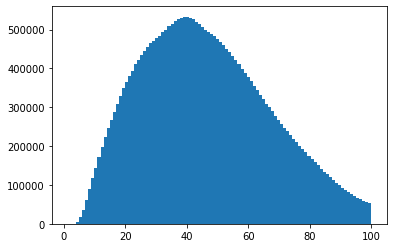

In [13]:
lengths = list(map(len, train_encoded))

plt.hist(lengths, bins=100, range=(1, 100))
plt.show()

In [20]:
min_len = 32
max_len = 64

max_train_samples = 250_000
max_test_samples = 10_000

postfix = '250k_10b'

filter_cond = lambda x: min_len <= len(x) <= max_len

In [21]:
def create_subset(samples, filter_cond, max_samples, shuffle=True):
    samples_by_id = [(i, sample) for i, sample in enumerate(samples)]
    filtered = list(filter(lambda pair: filter_cond(pair[1]), samples_by_id))
    if shuffle:
        random.shuffle(filtered)
    return list(zip(*filtered[:max_samples]))[0]

In [22]:
train_subset_ids = create_subset(train_encoded, filter_cond, max_train_samples)
test_subset_ids = create_subset(test_encoded, filter_cond, max_test_samples)

In [23]:
print(f'Final number of training subsamples: {len(train_subset_ids)}')
print(f'Final number of test subsamples: {len(test_subset_ids)}')

Final number of training subsamples: 250000
Final number of test subsamples: 10000


In [24]:
def save_subset(save_path, samples, subset_ids, bpe_path):
    save_path.write_bytes(
        pickle.dumps(dict(
            bpe_path=str(bpe_path),
            samples=[samples[idx] for idx in subset_ids],
            seq_length=max_len
        ))
    )

In [25]:
save_subset(root / f'train_{postfix}.p', train_encoded, train_subset_ids, model_path)
save_subset(root / f'test_{postfix}.p', test_encoded, test_subset_ids, model_path)